In [1]:
%matplotlib inline

import os
import tarfile
import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNetCV, LinearRegression


DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CombinedAttributesAdder: expected pandas DataFrame when used before ColumnTransformer.")
        X = X.copy()
        X["rooms_per_household"] = X["total_rooms"] / X["households"]
        X["population_per_household"] = X["population"] / X["households"]
        if self.add_bedrooms_per_room:
            X["bedrooms_per_room"] = X["total_bedrooms"] / X["total_rooms"]
        # X["log_median_income"] = np.log1p(X["median_income"])
        # X["income_rooms"] = X["median_income"] * X["rooms_per_household"]
        X["income_bedrooms"] = X["median_income"] * X.get("bedrooms_per_room", X["total_bedrooms"] / X["total_rooms"])
        X["age_income"] = X["housing_median_age"] * X["median_income"]
        return X



class CombinedAttributesDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_columns=["longitude", "total_bedrooms", "population", "households"]): # no *args or **kargs
        self.drop_columns = drop_columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CombinedAttributesDropper: expected pandas DataFrame.")
        return X.drop(self.drop_columns, axis=1)



df = load_housing_data()

# Best Linear Model

[66809.8816089  65699.04283368 65812.58470773 62169.67850475
 64505.08533582]
Mean: 64999.25459817469, Std: 1592.5001564799231
Test RMSE: 65871.5867159769


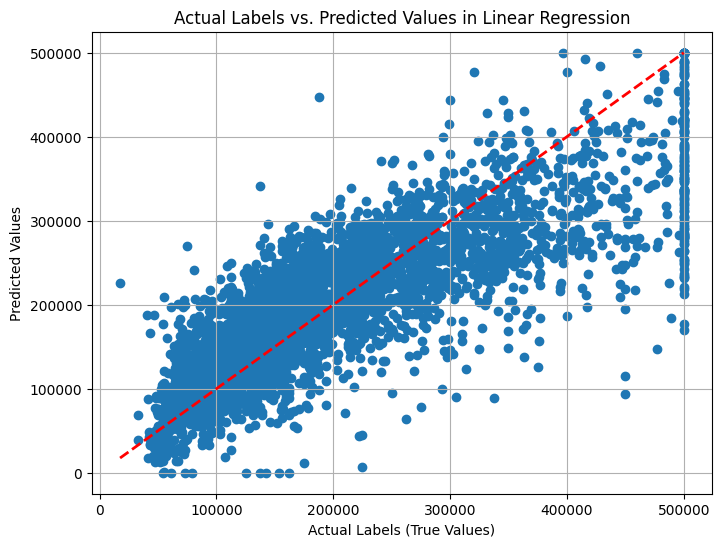

In [2]:
df = load_housing_data()

attr_list = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
for attr in attr_list:
    df = df.loc[df[attr] <= df[attr].quantile(0.995)].reset_index(drop=True)
    df = df.loc[df[attr] >= df[attr].quantile(0.005)].reset_index(drop=True)

df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"].copy()

# train - test split with stratification
test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in test_split.split(df, df["income_cat"]):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]

for set_ in (X_train, X_test):
    set_.drop("income_cat", axis=1, inplace=True)

adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
dropper = CombinedAttributesDropper() 
X_train_with_extra = adder.transform(X_train.copy())
drop_cols = dropper.drop_columns

cat_attribs = ["ocean_proximity"]
num_attribs = [c for c in X_train_with_extra.columns if c not in cat_attribs and c not in drop_cols]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

full_pipeline = Pipeline([
    ("attribs_adder",  adder),
    # ("attribs_dropper", dropper),
    ("preprocessor", ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])),
])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-scores)

print(rmse_scores)
print(f'Mean: {rmse_scores.mean()}, Std: {rmse_scores.std()}')

lin_reg.fit(X_train_prepared, y_train)
y_pred = lin_reg.predict(X_test_prepared)
y_pred = np.where(y_pred < 0, 0, y_pred)
y_pred = np.where(y_pred > 500000, 500000, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Linear Regression")
plt.grid(True)
plt.show()

# Initial Analysis

In [136]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


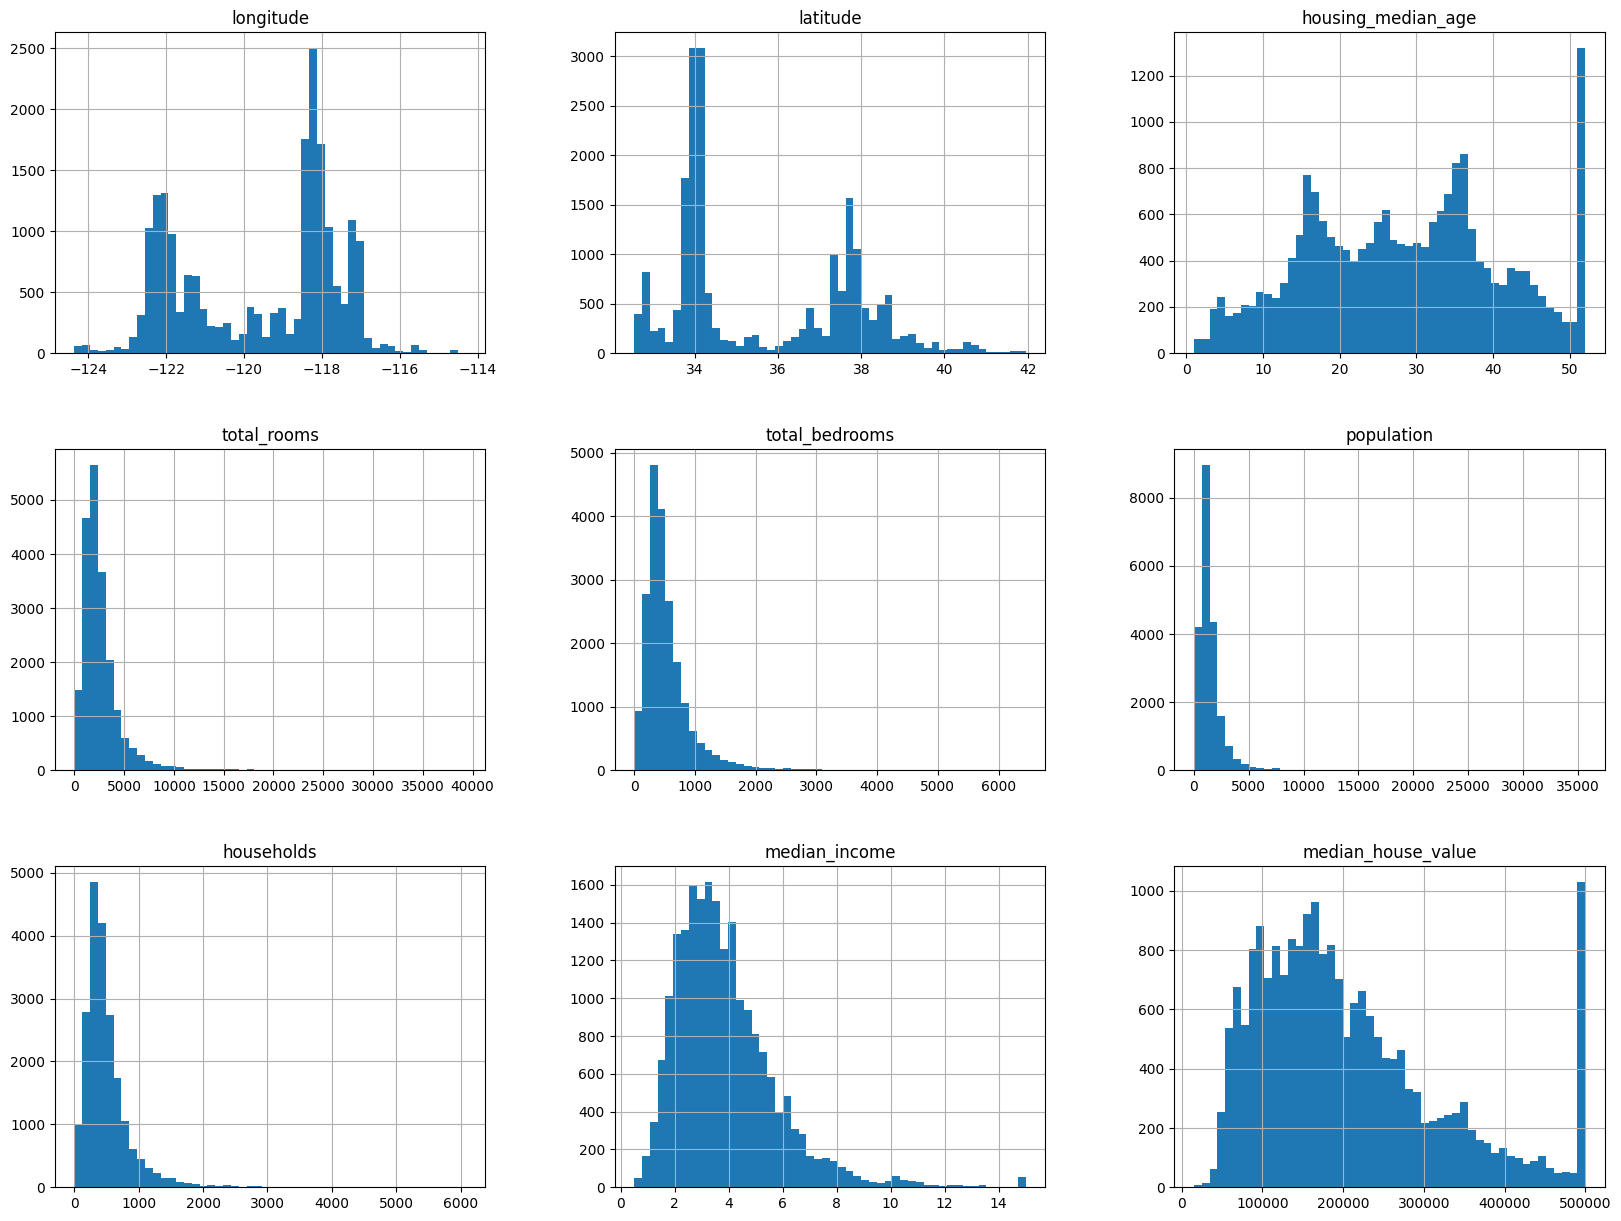

In [137]:
df.hist(bins=50, figsize=(20,15))
plt.show()

# Correlation Analysis

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

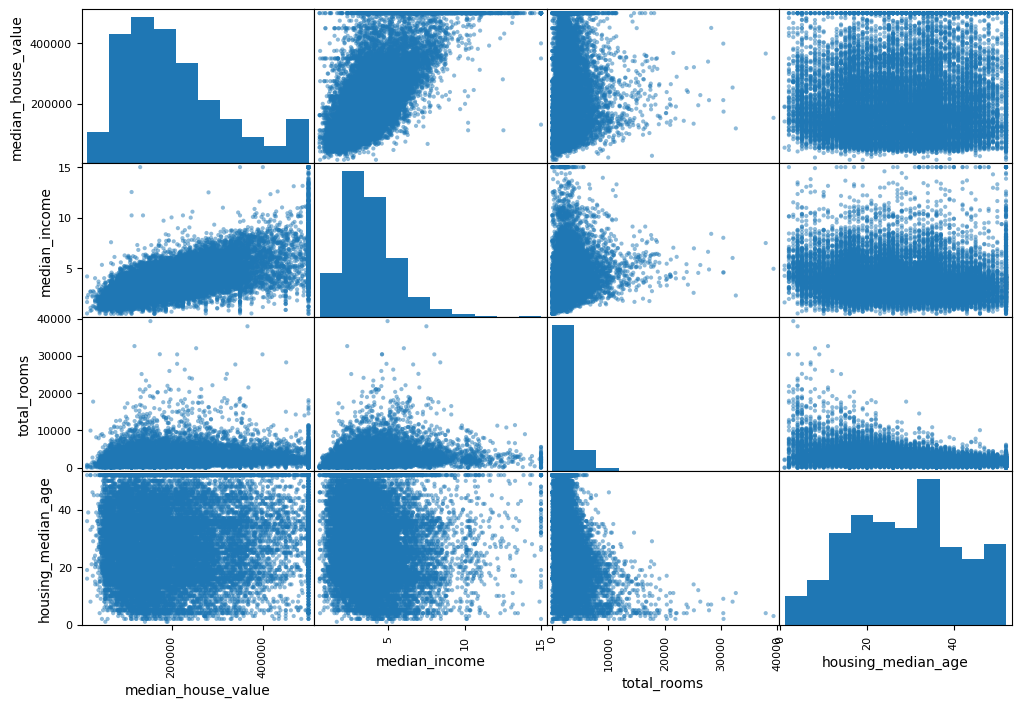

In [138]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(df[attributes], figsize=(12, 8))

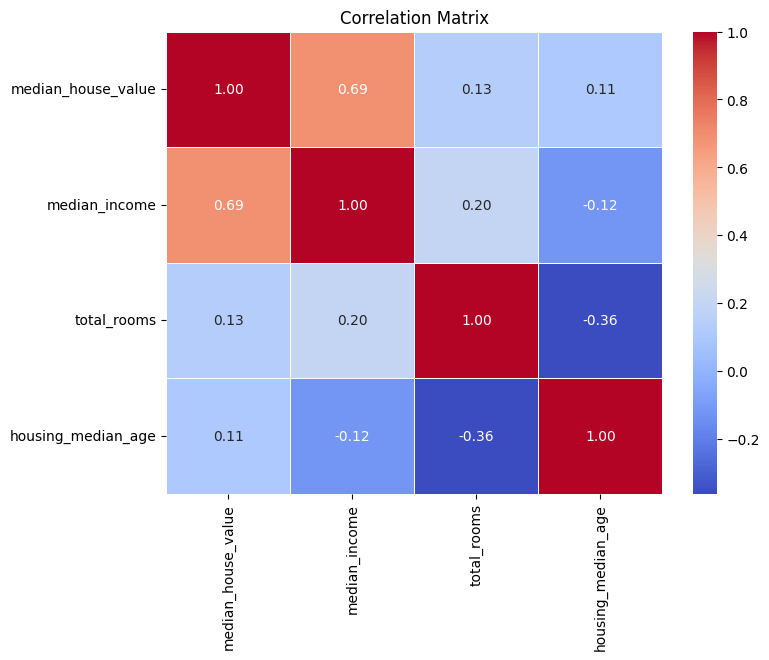

In [139]:
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(df[attributes].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64


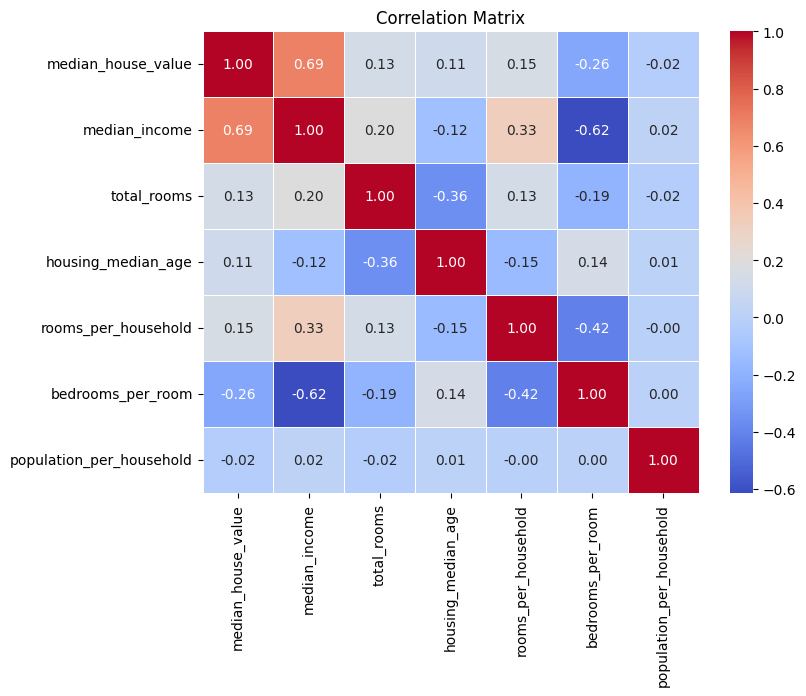

In [140]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"] = df["population"]/df["households"]

corr_matrix = df.drop('ocean_proximity', axis=1).corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age", "rooms_per_household", "bedrooms_per_room", "population_per_household"]
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(df[attributes].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [141]:
# Dropping so it can be added by custom pipeline function
df = df.drop(["rooms_per_household", "bedrooms_per_room", "population_per_household"], axis=1)

# Stratified Split

<Axes: >

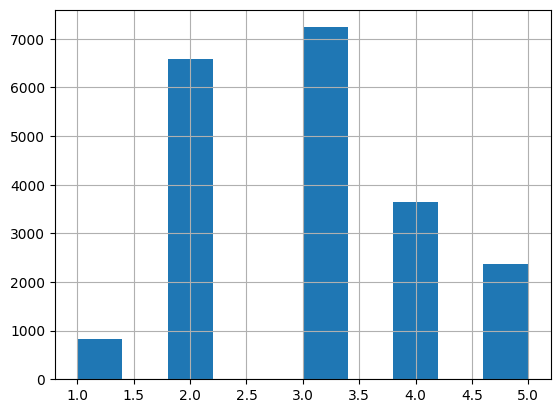

In [142]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

df["income_cat"].hist()

In [143]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

df = strat_train_set.copy()

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64


In [144]:
df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

# Processing Pipeline

In [145]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [147]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [149]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"] = df["population"]/df["households"]

corr_matrix = df.drop('ocean_proximity', axis=1).corr()
# print(corr_matrix["median_house_value"].sort_values(ascending=False))

In [150]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.028374,0.095645,-0.000415
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,0.107665,-0.116955,0.005426
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,-0.147184,0.136768,0.015031
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.127549,-0.192655,-0.024806
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.000426,0.086883,-0.028364
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.074665,0.037736,0.076232
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,-0.082971,0.067090,-0.027411
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.311528,-0.624650,0.021815
rooms_per_household,-0.028374,0.107665,-0.147184,0.127549,0.000426,-0.074665,-0.082971,0.311528,1.000000,-0.398529,-0.005316
bedrooms_per_room,0.095645,-0.116955,0.136768,-0.192655,0.086883,0.037736,0.067090,-0.624650,-0.398529,1.000000,0.004284


# First Version of Linear Model

Root Mean Squared Error: 68160.92435491859


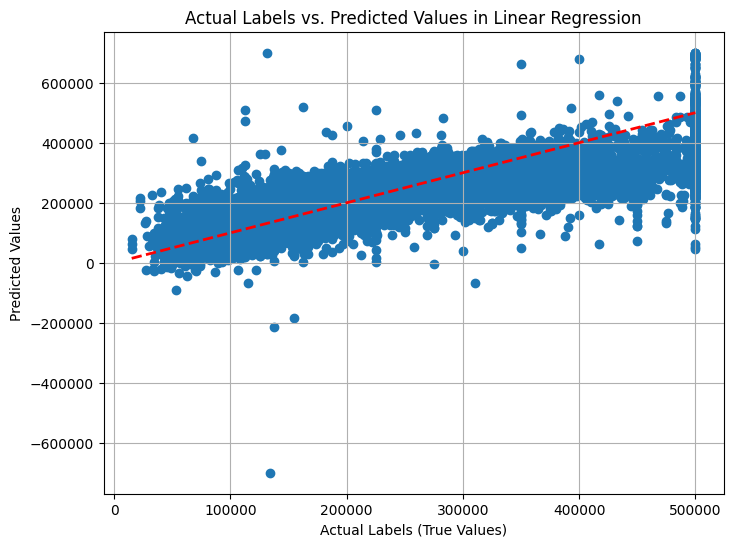

In [153]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

num_attribs = list(df.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

df_prepared = full_pipeline.fit_transform(df)

lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

y_test = df_labels
y_pred = lin_reg.predict(df_prepared)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Linear Regression")
plt.grid(True)
plt.show()

# Removing Outliers

In [154]:
df = load_housing_data()

display(df.shape)
attr_list = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
for attr in attr_list:
    df = df.loc[df[attr] <= df[attr].quantile(0.995)].reset_index(drop=True)
    df = df.loc[df[attr] >= df[attr].quantile(0.005)].reset_index(drop=True)
display(df.shape)

df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

(20640, 10)

(19381, 10)

Root Mean Squared Error: 64301.69394485457


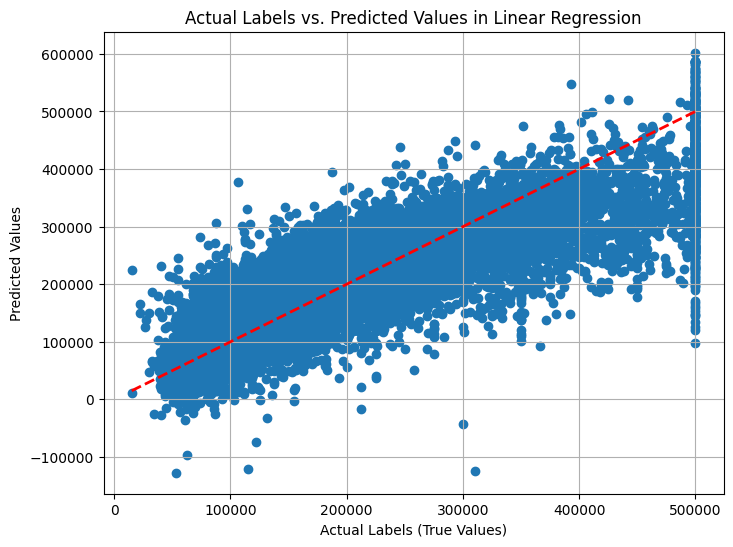

In [155]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

num_attribs = list(df.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

df_prepared = full_pipeline.fit_transform(df)

lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

y_test = df_labels
y_pred = lin_reg.predict(df_prepared)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Linear Regression")
plt.grid(True)
plt.show()

Root Mean Squared Error: 64046.35212038264


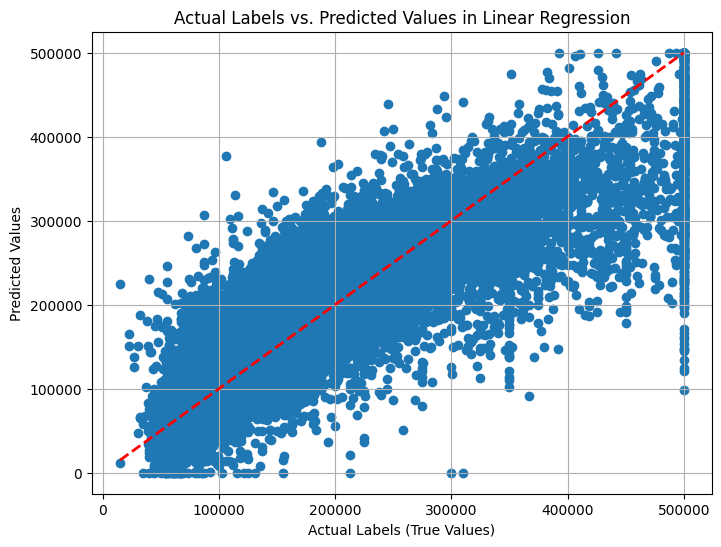

In [156]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

num_attribs = list(df.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

df_prepared = full_pipeline.fit_transform(df)

lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

y_test = df_labels
y_pred = lin_reg.predict(df_prepared)
y_pred = np.where(y_pred < 0, 0, y_pred)
y_pred = np.where(y_pred > 500000, 500000, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=1) # Plot actual labels vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a perfect prediction line (red dashed)
plt.xlabel("Actual Labels (True Values)")
plt.ylabel("Predicted Values")
plt.title("Actual Labels vs. Predicted Values in Linear Regression")
plt.grid(True)
plt.show()

# Using Cross Validation

In [157]:
df = load_housing_data()

attr_list = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
for attr in attr_list:
    df = df.loc[df[attr] <= df[attr].quantile(0.995)].reset_index(drop=True)
    df = df.loc[df[attr] >= df[attr].quantile(0.005)].reset_index(drop=True)

df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"].copy()

# train - test split with stratification
test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in test_split.split(df, df["income_cat"]):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]

for set_ in (X_train, X_test):
    set_.drop("income_cat", axis=1, inplace=True)


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

num_attribs = list(X_train.drop("ocean_proximity", axis=1).columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

enet_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    cv=5,
    max_iter=10000,
    random_state=42,
    n_jobs=-1,
)
enet_cv.fit(X_train_prepared, y_train)

print("Best alpha:", enet_cv.alpha_)
print("Best l1_ratio:", enet_cv.l1_ratio_)


y_train_pred = enet_cv.predict(X_train_prepared)
y_test_pred = enet_cv.predict(X_test_prepared)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# Slight overfitting

Best alpha: 79.02294814078293
Best l1_ratio: 1.0
Train RMSE: 64373.26
Test RMSE: 66059.62


# Dropping less relevant features

In [158]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"] = df["population"]/df["households"]

corr_matrix = df.drop('ocean_proximity', axis=1).corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.694262
income_cat                  0.645521
rooms_per_household         0.200557
total_rooms                 0.175368
housing_median_age          0.114385
households                  0.083387
total_bedrooms              0.063250
population                 -0.041001
longitude                  -0.046242
latitude                   -0.144729
population_per_household   -0.252435
bedrooms_per_room          -0.255990
Name: median_house_value, dtype: float64


In [159]:
df = load_housing_data()

attr_list = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
for attr in attr_list:
    df = df.loc[df[attr] <= df[attr].quantile(0.995)].reset_index(drop=True)
    df = df.loc[df[attr] >= df[attr].quantile(0.005)].reset_index(drop=True)

df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"].copy()

test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in test_split.split(df, df["income_cat"]):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]

for set_ in (X_train, X_test):
    set_.drop("income_cat", axis=1, inplace=True)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

num_attribs = list(X_train.drop("ocean_proximity", axis=1).columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-scores)

print(rmse_scores)
print(f'Mean: {rmse_scores.mean()}, Std: {rmse_scores.std()}')

lin_reg.fit(X_train_prepared, y_train)
y_pred = lin_reg.predict(X_test_prepared)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

[64908.25939091 65670.06875935 65166.90278706 61836.99617153
 64252.87092113]
Mean: 64367.01960599465, Std: 1344.9713160791996
Test RMSE: 66091.43925431282
